This notebook illustrates the first experiment (5.1 Pointwise ROC Optimization) described in:


*A Probabilistic Theory of Supervised Similarity Learning for Pointwise ROC Curve Optimization.*
Robin Vogel, Aurélien Bellet, Stéphan Clémençon ; Proceedings of the 35th International Conference on Machine Learning, PMLR 80:5062-5071, 2018.

# Preliminaries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
np.random.seed(42)

In [4]:
def ang_to_cart(ang, r=1):
    """ 
        Transforms angular coordinates to cartesian coordinates in R^3.
        Parameters:
        * ang: pair (theta, phi).
        * r: distance to the origin of point.
        Returns:
        * [x,y,z]: cartesian coordinates in R^3.
    """
    theta, phi = ang[0], ang[1]
    theta = theta % (2*np.pi)
    phi = phi % (2*np.pi)
    if phi > np.pi:
        phi = np.abs(2*np.pi-phi)
        theta = (theta + np.pi ) % (2*np.pi)
    return r*np.array([np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi)])

# Data generation

In [5]:
def uniform_ball_datagen(n=200, pks=np.array([0.5, 0.5]),
                       centroids=np.array([[1., 0.], [0., 1.]]),
                       angs=[0.5, 0.2]):
    """
    Returns data generated uniformly around the centroids with specified angular delta.
    Parameters:
    * n: number of points to generate.
    * pks: probability to belong to one of each class. Sums to one.
    * centroids: centers of clusters.
    * angs: defines the angular delta for each class.
    Returns:
    * (X, Y): X coordinates of generated points, Y labels of points.
    """
    D = len(centroids[0])
    Y = list()
    X = list()
    for i in range(0, n):
        y = np.argmax(np.random.uniform(0, 1) < pks.cumsum())
        condition = True
        while condition: # generate greedily a point at the right distance of its centroid
            x = np.random.normal(0,1,size=D)
            x = x/np.linalg.norm(x)
            condition = np.linalg.norm(x-centroids[y]) > np.sin(angs[y])
        Y.append(y)
        X.append(x)
    return np.array(X), np.array(Y)

In [6]:
n = 400
n_test = 10000

K = 3 # n_classes
D = 3 # number of dimensions

alpha = 0.2

ang_centroids = [np.array([np.pi/3, np.pi/2]), np.array([np.pi/2, np.pi/2]), np.array([0, 0])]
centroids = [ang_to_cart(ang) for ang in ang_centroids]

pks = np.array([1/3,1/3,1/3])
angs = [np.pi/4, np.pi/4, np.pi/4]

In [7]:
X, Y = uniform_ball_datagen(n=n, pks=pks, centroids=centroids, angs=angs)
X_test, Y_test = uniform_ball_datagen(n=n_test, pks=pks, centroids=centroids, angs=angs)

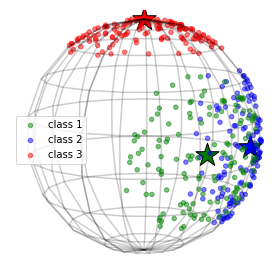

In [11]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
ax.scatter(X[Y==0, 0], X[Y==0, 1], X[Y==0, 2], c="green", marker="o", alpha=0.5, label="class 1")
ax.scatter(X[Y==1, 0], X[Y==1, 1], X[Y==1, 2], c="blue", marker="o", alpha=0.5, label="class 2")
ax.scatter(X[Y==2, 0], X[Y==2, 1], X[Y==2, 2], c="red", marker="o", alpha=0.5, label="class 3")

# Plotting the centroids
ax.scatter(centroids[0][0], centroids[0][1], centroids[0][2], 
           c="green", s=600, marker="*", edgecolor='black') #, label="centroid 0")
ax.scatter(centroids[1][0], centroids[1][1], centroids[1][2], 
           c="blue", s=600, marker="*", edgecolor='black')  #, label="centroid 1")
ax.scatter(centroids[2][0], centroids[2][1], centroids[2][2], 
           c="red", s=600, marker="*", edgecolor='black') #, label="centroid 2")


# Drawing the sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
xs = np.cos(u)*np.sin(v)
ys = np.sin(u)*np.sin(v)
zs = np.cos(v)
ax.plot_wireframe(xs, ys, zs, color="black", alpha=0.2) # marker="--")

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

lim_plot = 1.3

ax.set_xlim(-lim_plot,lim_plot)
ax.set_ylim(-lim_plot,lim_plot)
ax.set_zlim(-lim_plot,lim_plot)

angle = 30

plt.legend(loc="center left")

ax.view_init(10, angle)
plt.tight_layout()

a = ["","","","","", "","","",""]
ax.set_zticklabels(a)
ax.set_yticklabels(a)
ax.set_xticklabels(a)
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.dist = 4.6

plt.savefig('simulated_data.pdf', format='pdf', dpi=1000)

plt.show()

# Solution

Introduce, with $A \in \mathbb{R}^{d\times d}$,
$$
\begin{align*}
S_A(x,x') = \frac{1}{2} \left ( 1 + x^\top A x' \right ),
\end{align*}
$$
we tackle:
$$
\begin{align*}
\max_{A \in \mathbb{R}^{d\times d}} \; & \frac{1}{n_+} \sum_{1\le i < j \le n} 
\mathbb{I} \left \{ Y_i = Y_j \right \} \cdot S_A \left ( X_i,X_j \right ), \\
\text{s.t.} \; & \frac{1}{n_-} \sum_{1\le i < j \le n} \mathbb{I}\left \{ Y_i \ne Y_j \right \} \cdot
S_A \left ( X_i, X_j \right ) \le \alpha, \\
& ||A||_F^2 \le 1.
\end{align*}
$$

In [77]:
class Pointwise_ROC_linear_sim:
    def b_to_a(self, beta):
        """ 
        Goes from beta to alpha, see paper, R -> R.
        """
        return (beta + 1)/2
    
    def a_to_b(self, alpha):
        """
        Goes from alpha to beta, see paper, R -> R.
        """
        return 2*alpha - 1
    
    def evaluate_P_N(self, X, Y):
        """
        Evaluates P and N from X and Y, see paper.
        """
        pos_avg, neg_avg = (0,0)
        n_pos, n_neg = (0,0)
        avg_fun = lambda x, xp: x.transpose().dot(xp) + xp.transpose().dot(x)
        for i in range(0, self.n-1):
            for j in range(i+1, self.n):
                if Y[i] == Y[j]:
                    pos_avg += avg_fun(X[i:(i+1), :],X[j:(j+1), :])
                    n_pos += 1
                else:
                    neg_avg += avg_fun(X[i:(i+1), :], X[j:(j+1), :])
                    n_neg += 1
        return pos_avg/(2*n_pos), neg_avg/(2*n_neg)
        
    def __init__(self, X, Y):
        """
        Inits the learner on data X and Y.
        """
        self.X = X
        self.Y = Y
                
        self.n = X.shape[0]
        self.D = X.shape[1]
                            
        self.P, self.N = self.evaluate_P_N(self.X, self.Y)
                    
        self.eps = np.finfo(float).eps  # machine epsilon
        
        self.PP = np.power(self.P, 2).sum()
        self.NN = np.power(self.N, 2).sum()
        self.PN = (self.P*self.N).sum()
        
        self.max_beta = self.PN/np.sqrt(self.PP)
        self.min_beta = - np.sqrt(self.NN)
        self.A = None
        print("Max value of alpha leading to saturation of the constraint: {:2.4f}".format(self.b_to_a(self.max_beta)))
        print("Min value of alpha for feasibility: {:2.4f}".format(self.b_to_a(self.min_beta)))
        
    def print_objectives(self):
        pos_obj = (self.P*self.A).sum()
        neg_cons = (self.N*self.A).sum()
        norm_cons = (self.A*self.A).sum()
        print("obj = {:2.4f}, neg_cons = {:2.4f}, norm_cons = {:2.4f} ".format(pos_obj, neg_cons, norm_cons))
            
    def check_feasibility(self):
        return (self.beta >= - np.sqrt(self.NN))
    
    def check_pos_colin(self):
        mat = self.P/self.N
        return np.max(mat)-np.min(mat) < self.eps
    
    def fit(self, alpha = 0.):
        """
        Gives the result of the optimization problem, is based of classic Lagrangian optimization.
        """
        print("Call to the function with alpha: {:2.4f}".format(alpha))
        self.beta = self.a_to_b(alpha)
        if self.check_feasibility():
            if self.PP < self.eps:
                print("Case 1: P is equal to zero, getting a feasible solution.")
                # gamma = 0, lambda = 0
                if self.beta >= 0:
                    coef = 0
                else:
                    coef = - 1/np.sqrt(self.NN)
                self.A = coef*self.N
            elif self.check_pos_colin() and np.abs(self.beta) <= np.sqrt(self.NN):
                print("Case 2: P and N positively colinear.")
                # gamma = 0, lambda > 0 
                coef = self.beta/self.NN
                self.A = coef*self.N
            elif self.PN/np.sqrt(self.PP) < self.beta:
                print("Case 3: Constraint on alpha not saturated.")
                # gamma > 0, lambda = 0
                self.A = self.P/np.sqrt(self.PP)
            else:
                print("Case 4: Both constraints saturated.")
                # gamma > 0, lambda > 0
                if np.abs(self.beta) < self.eps:
                    lambd = self.PN/self.NN
                    gamma = np.sqrt(self.PP - (self.PN**2)/self.NN)/2
                else:
                    a = self.NN - (self.NN/self.beta)**2
                    b = 2*self.PN*( self.NN/(self.beta)**2 - 1 )
                    c = self.PP - (self.PN/self.beta)**2
                    delta = b**2 - 4*a*c
                    lambda_1 = (-b + np.sqrt(delta)) / (2 * a)
                    lambda_2 = (-b - np.sqrt(delta)) / (2 * a)
                    print("Solutions for lambda: {:2.4f} / {:2.4f}".format(lambda_1, lambda_2))
                    if lambda_1 >= 0 and lambda_2 < 0:
                        lambd = lambda_1
                        gamma = (self.PN - lambd*self.NN)/(2*self.beta)
                    elif lambda_1 < 0 and lambda_2 >= 0:
                        lambd = lambda_2
                        gamma = (self.PN - lambd*self.NN)/(2*self.beta)
                    else:
                        gamma_1 = (self.PN - lambda_1*self.NN)/(2*self.beta)
                        gamma_2 = (self.PN - lambda_2*self.NN)/(2*self.beta)
                        print("Solutions for gamma: {:2.4f} / {:2.4f}".format(gamma_1, gamma_2))
                        if gamma_1 > 0 :
                            gamma, lambd = gamma_1, lambda_1
                        else:
                            gamma, lambd = gamma_2, lambda_2
                print("Final lambda = {:2.4f} / gamma = {:2.4f} ".format(lambd, gamma))
                self.A = (self.P/gamma - (lambd/gamma)*self.N)/2
        else:
            print("Unfeasible problem.")

In [78]:
prob_lagrangian = Pointwise_ROC_linear_sim(X, Y)

Max value of alpha leading to saturation of the constraint: 0.5822
Min value of alpha for feasibility: 0.2963


In [79]:
prob_lagrangian.fit(0.58)

Call to the function with alpha: 0.5800
Case 4: Both constraints saturated.
Solutions for lambda: 0.0174 / 1.0677
Solutions for gamma: 0.2723 / -0.2723
Final lambda = 0.0174 / gamma = 0.2723 


In [80]:
def ROC_from_data(X, Y, M, n_scores_pos=5000, n_scores_neg=5000):
    """
    Computes the ROC curves associated to a linear similarity x'^T M x.
    Parameters:
    * X: data points, in R^(n*d).
    * Y: class membership of data points, in {1, ..., K}^{n}.
    * M: matrix for linear similarity, in R^(d*d).
    * n_scores_pos: number D_p of positive scores to compute.
    * n_scores_neg: number D_n of negative scores to compute.
    Returns:
    * (fpr, tpr): False positive rate array and true positive rate array, both in in R^(D_p + D_n).
    """
    n = X.shape[0]
    classes = np.unique(Y)
    d_classes = {k: list(np.where(Y==k)[0]) for k in classes}
    scores = list()
    
    print("Getting scores...")
    for _ in range(n_scores_pos):
        i = np.random.randint(n)
        j = np.random.choice([j_p for j_p in d_classes[Y[i]] if j_p != i])
        score = 0.5*(1 + X[i:(i+1), :].dot(M).dot(X[j:(j+1), :].transpose()))
        scores.append([+1, score])
    print("Gotten positives...")
    
    for _ in range(n_scores_neg):
        i = np.random.randint(n)
        complementary_elems = [j_p for i_c in classes if i_c != Y[i] for j_p in d_classes[i_c]]
        j = np.random.choice(complementary_elems)
        score = 0.5*(1 + X[i:(i+1), :].dot(M).dot(X[j:(j+1), :].transpose()))
        scores.append([-1, score])
    print("Gotten negatives...")
    
    scores = np.array(scores)
    n_p_tot = (scores[:, 0].sum() + scores.shape[0])/2
    n_n_tot = scores.shape[0] - n_p_tot
    order_scores = np.argsort(scores[:, 1])
    sorted_scores = np.flip(scores[order_scores, :], 0)
    tp = ((sorted_scores[:, 0]+1)/2).cumsum()/n_p_tot
    fp = ((sorted_scores[:, 0]-1)/(-2)).cumsum()/n_n_tot
    print("Gotten ROC curve...")
    
    return fp, tp

In [81]:
ROC_P = ROC_from_data(X_test, Y_test, prob_lagrangian.P)

Getting scores...
Gotten positives...
Gotten negatives...
Gotten ROC curve...


In [82]:
ROC_N = ROC_from_data(X_test, Y_test, -prob_lagrangian.N)

Getting scores...
Gotten positives...
Gotten negatives...
Gotten ROC curve...


In [85]:
alpha_small = 0.32
prob_lagrangian.fit(alpha_small)
A_alpha_small = prob_lagrangian.A 

Call to the function with alpha: 0.3200
Case 4: Both constraints saturated.
Solutions for lambda: -1.7793 / 2.8645
Final lambda = 2.8645 / gamma = 0.5352 


In [86]:
ROC_alpha_small = ROC_from_data(X_test, Y_test, A_alpha_small)

Getting scores...
Gotten positives...
Gotten negatives...
Gotten ROC curve...


In [94]:
alpha_large = 0.54
prob_lagrangian.fit(alpha_large)
A_alpha_large = prob_lagrangian.A 

Call to the function with alpha: 0.5400
Case 4: Both constraints saturated.
Solutions for lambda: 0.2963 / 0.7889
Solutions for gamma: 0.2554 / -0.2554
Final lambda = 0.2963 / gamma = 0.2554 


In [95]:
ROC_alpha_large = ROC_from_data(X_test, Y_test, A_alpha_large)

Getting scores...
Gotten positives...
Gotten negatives...
Gotten ROC curve...


In [96]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 22, 'font.serif': ['Bookman']}) 

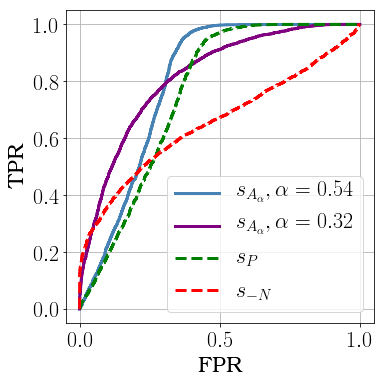

In [97]:
plt.figure(figsize=(5.8,5.8))
linewidth = 3
# str_num = str(round((alpha+1)/2,2))[:5]
plt.plot(*ROC_alpha_large, label="$s_{A_\\alpha},\\alpha = "+str(alpha_large)+"$", 
         color = "steelblue", linewidth=linewidth)
plt.plot(*ROC_alpha_small, label="$s_{A_\\alpha},\\alpha = "+str(alpha_small)+"$", 
         color = "purple", linewidth=linewidth)
plt.plot(*ROC_P, "g--", label="$s_P$", linewidth=linewidth)
plt.plot(*ROC_N, "r--", label="$s_{-N}$", linewidth=linewidth)
# plt.plot([0,1], [0,1], "black", style="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()

# plt.xscale("log")
# plt.title("ROC curve")
plt.legend()
# plt.xlim([0.8,1.])
# plt.ylim([0.85,1.])
plt.tight_layout()

plt.savefig('ROCs.pdf', format='pdf', dpi=1000)

plt.show()